HOTEL BOOKING CANCELLATION PREDICTION - DATA PREPROCESSING
Dataset loaded successfully: (119390, 32)

First 5 rows:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights

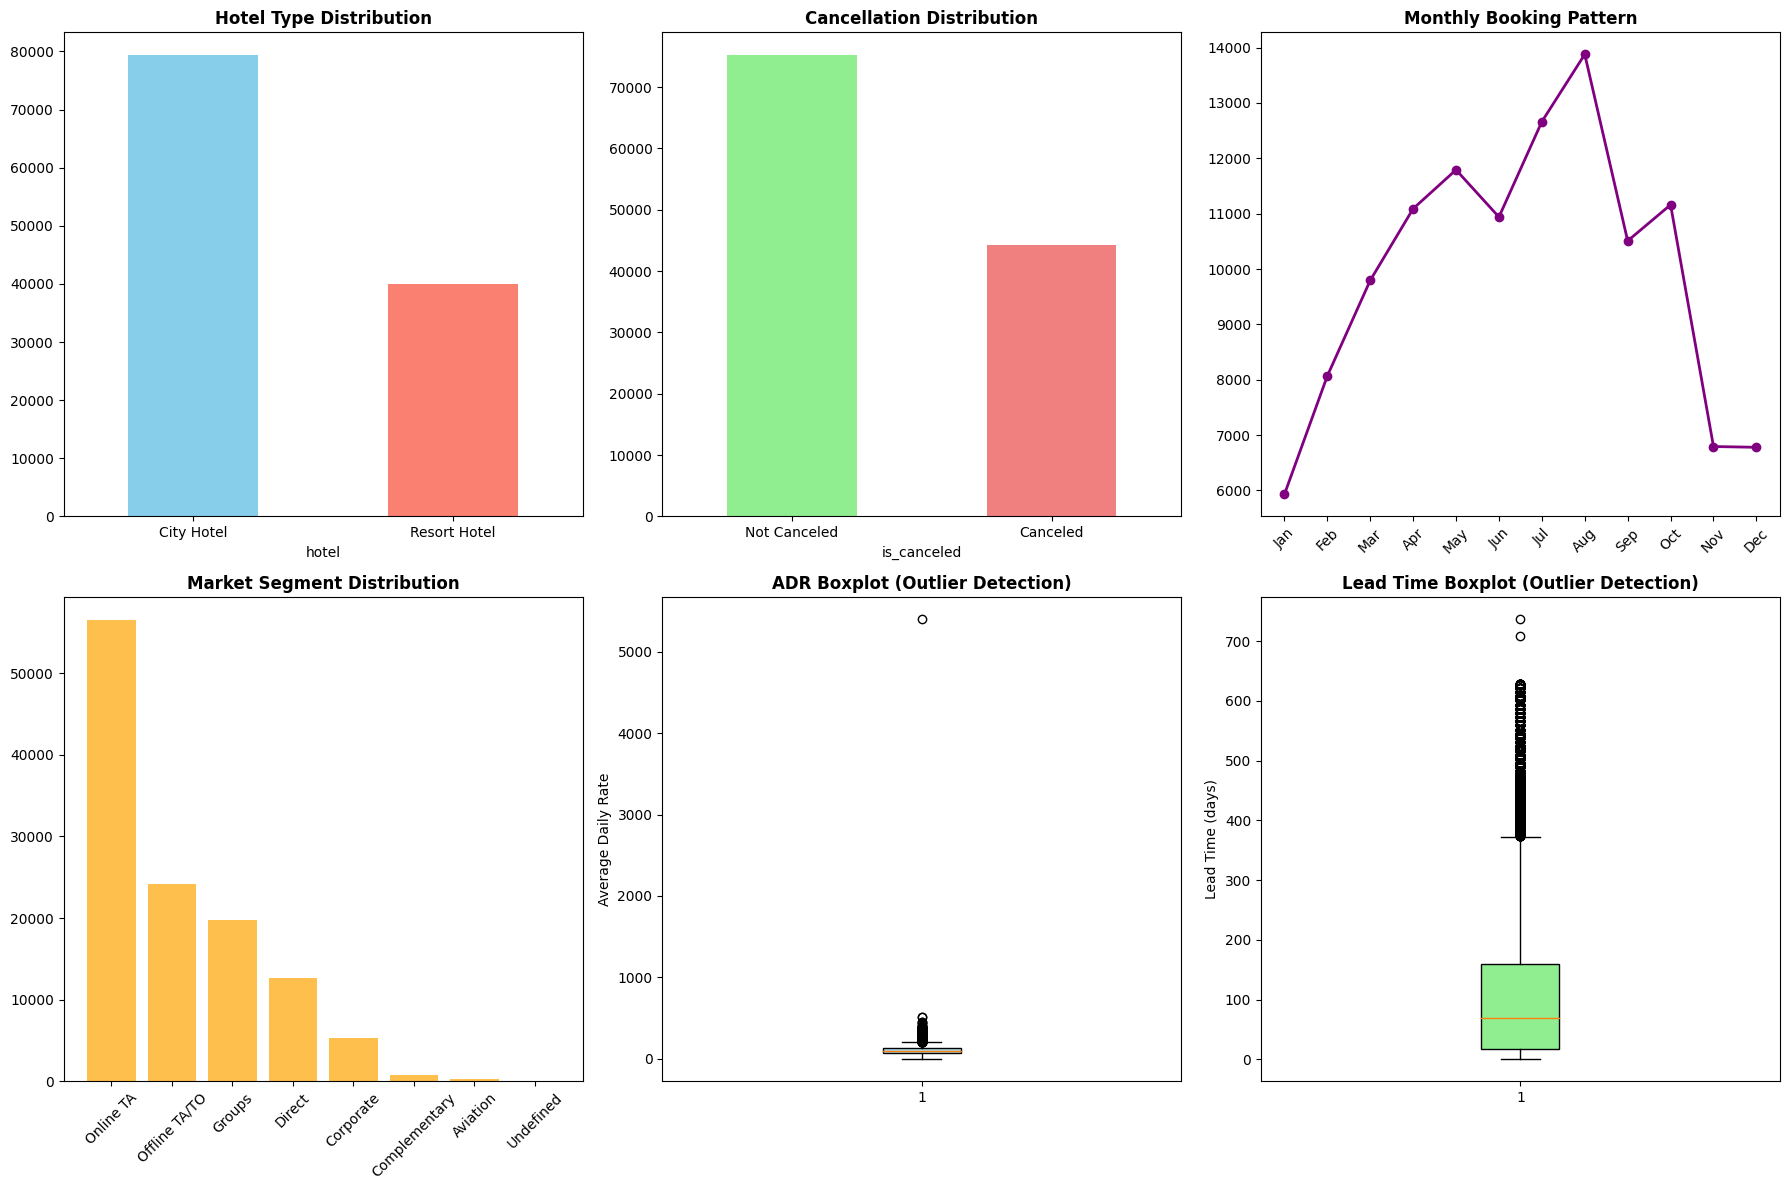


MISSING DATA VISUALIZATION:


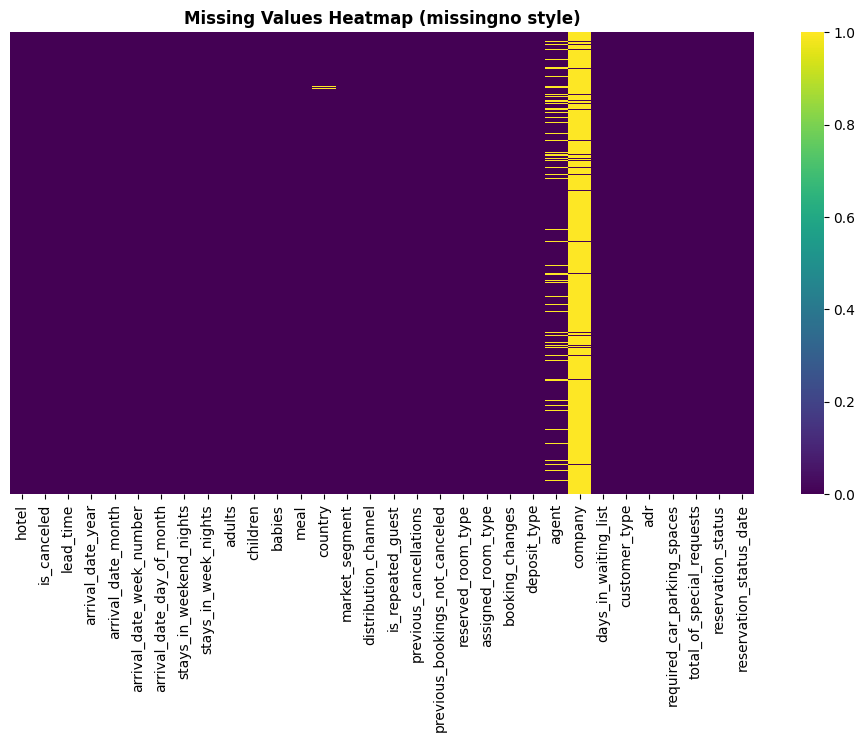

          Missing Values  Percentage
children               4    0.003350
country              488    0.408744
agent              16340   13.686238
company           112593   94.306893


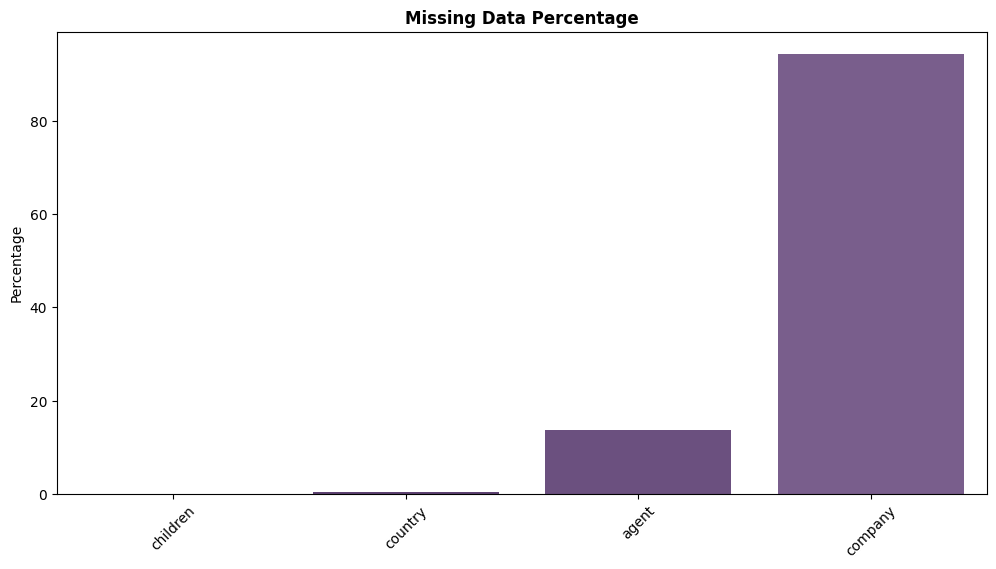

DATA CLEANING PROCESS
REMOVING DATA LEAKAGE COLUMNS:
Removed: ['reservation_status', 'reservation_status_date']

REMOVING DUPLICATES: Removed 32252 duplicate rows
New shape: (87138, 30)

HANDLING MISSING VALUES:
Company: Filled 81890 missing values with 'None'
Agent: Filled 12160 missing values with 0
Country: Filled 451 missing values with mode 'PRT'
Children: Filled 4 missing values with median 0.0

Missing values after cleaning: 0

OUTLIER DETECTION AND HANDLING (IQR METHOD):
adr: 2485 outliers detected (2.9%)
lead_time: 2371 outliers detected (2.7%)

CAPPING OUTLIERS:
ADR: Capped 1 values above 1000
Lead Time: Capped 559 values above 365 days

FIXING DATA TYPES:
Fixed: children and agent converted to int64

DATA CLEANING COMPLETED! Final missing values: 0
FEATURE ENGINEERING & PREPROCESSING
CREATING NEW FEATURES:
Created:
  total_guests = adults + children + babies
  total_nights = stays_in_weekend_nights + stays_in_week_nights
  is_family = binary flag for bookings with children/b

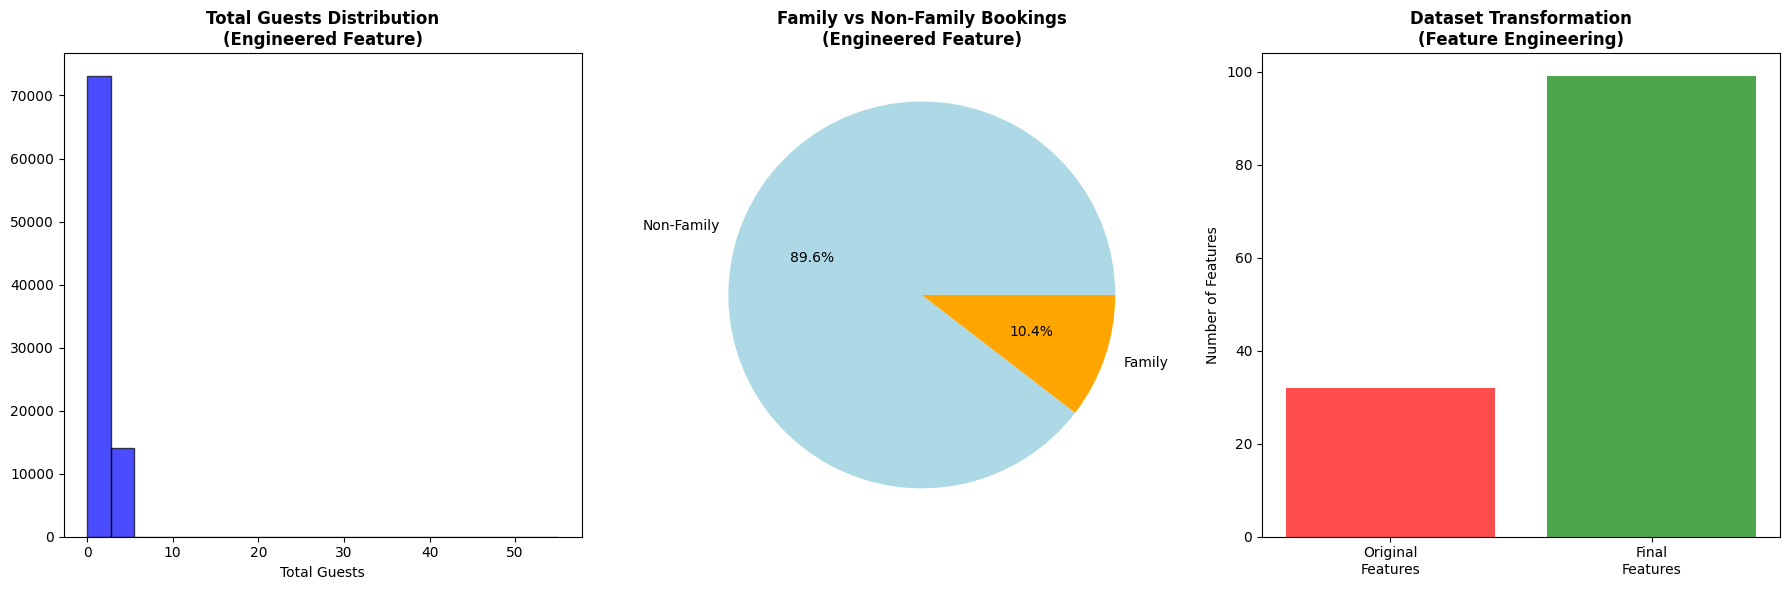


FINAL VERIFICATION:
Missing values remaining: 0
Dataset shape: (87138, 100)
Features ready for ML: 99
Data leakage removed: YES
Outliers handled: YES
Categorical encoding: YES
New features created: YES

DATASET READY FOR MACHINE LEARNING MODELING


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

print("Hotel Booking_Data Cleaning & Preprocessing Challenge")

# Upload Data
df = pd.read_csv('/kaggle/input/hotel-booking/hotel_bookings.csv')
print(f"Dataset loaded successfully: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# EXPLORATORY DATA ANALYSIS (EDA)
print("EXPLORATORY DATA ANALYSIS (EDA)")

print("\nDataset Information (.info()):")
df.info()
print("\nSummary Statistics (.describe()):")
print(df.describe())
print(f"\nDataset Shape: {df.shape}")
print(f"Unique values per column:\n{df.nunique()}")

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(f"\nMissing Values Analysis:\n{missing_values}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# Data Visualization (EDA)
print("\nCreating Visualizations...")
plt.style.use('default')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Hotel type distribution
df['hotel'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Hotel Type Distribution', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=0)

# Plot 2: Cancellation distribution
df['is_canceled'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['lightgreen', 'lightcoral'])
axes[0, 1].set_title('Cancellation Distribution', fontweight='bold')
axes[0, 1].set_xticklabels(['Not Canceled', 'Canceled'], rotation=0)

# Plot 3: Monthly arrival pattern
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
month_counts = df['arrival_date_month'].value_counts().reindex(month_order)
axes[0, 2].plot(month_counts.values, marker='o', color='purple', linewidth=2)
axes[0, 2].set_title('Monthly Booking Pattern', fontweight='bold')
axes[0, 2].set_xticks(range(12))
axes[0, 2].set_xticklabels([m[:3] for m in month_order], rotation=45)

# Plot 4: Market segment
market_counts = df['market_segment'].value_counts()
axes[1, 0].bar(range(len(market_counts)), market_counts.values, color='orange', alpha=0.7)
axes[1, 0].set_title('Market Segment Distribution', fontweight='bold')
axes[1, 0].set_xticks(range(len(market_counts)))
axes[1, 0].set_xticklabels(market_counts.index, rotation=45)

# Plot 5: ADR boxplot for outlier detection (REQUIRED)
axes[1, 1].boxplot(df['adr'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1, 1].set_title('ADR Boxplot (Outlier Detection)', fontweight='bold')
axes[1, 1].set_ylabel('Average Daily Rate')

# Plot 6: Lead time boxplot for outlier detection (REQUIRED)
axes[1, 2].boxplot(df['lead_time'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[1, 2].set_title('Lead Time Boxplot (Outlier Detection)', fontweight='bold')
axes[1, 2].set_ylabel('Lead Time (days)')

plt.tight_layout()
plt.show()

# Visualizing Missing Data
print("\nMISSING DATA VISUALIZATION:")
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap (missingno style)', fontweight='bold')
plt.show()

# Missing values analysis
missing_table = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Percentage": df.isnull().mean().mul(100)
}).loc[lambda x: x["Missing Values"] > 0].sort_values("Percentage")
print(missing_table)

# Missing values visualization
colors = ["#512d6d", "#5f3a7a", "#6c4887", "#7a5694"]
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_table.index, y=missing_table["Percentage"], palette=colors)
plt.xticks(rotation=45)
plt.title("Missing Data Percentage", fontweight='bold')
plt.ylabel("Percentage")
plt.show()

# DATA CLEANING PROCESS
print("DATA CLEANING PROCESS")

# CRITICAL: Remove data leakage columns FIRST (REQUIRED)
print("REMOVING DATA LEAKAGE COLUMNS:")
leakage_cols = ['reservation_status', 'reservation_status_date']
df = df.drop(leakage_cols, axis=1)
print(f"Removed: {leakage_cols}")

# Remove duplicates (REQUIRED)
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
print(f"\nREMOVING DUPLICATES: Removed {duplicates_before} duplicate rows")
print(f"New shape: {df.shape}")

# Handle missing values with REQUIRED strategies
print(f"\nHANDLING MISSING VALUES:")
company_missing = df['company'].isnull().sum()
df['company'] = df['company'].fillna('None')
print(f"Company: Filled {company_missing} missing values with 'None'")

agent_missing = df['agent'].isnull().sum()
df['agent'] = df['agent'].fillna(0)
print(f"Agent: Filled {agent_missing} missing values with 0")

country_missing = df['country'].isnull().sum()
mode_country = df['country'].mode()[0]
df['country'] = df['country'].fillna(mode_country)
print(f"Country: Filled {country_missing} missing values with mode '{mode_country}'")

children_missing = df['children'].isnull().sum()
median_children = df['children'].median()
df['children'] = df['children'].fillna(median_children)
print(f"Children: Filled {children_missing} missing values with median {median_children}")

print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")

# Handle outliers using IQR method (REQUIRED)
print(f"\nOUTLIER DETECTION AND HANDLING (IQR METHOD):")
numerical_cols = ['adr', 'lead_time']

for col in numerical_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers_before = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    print(f"{col}: {outliers_before} outliers detected ({outliers_before / len(df):.1%})")

# Cap outliers (REQUIRED method)
print(f"\nCAPPING OUTLIERS:")
adr_outliers = len(df[df['adr'] > 1000])
df.loc[df['adr'] > 1000, 'adr'] = 1000
print(f"ADR: Capped {adr_outliers} values above 1000")

lead_outliers = len(df[df['lead_time'] > 365])
df.loc[df['lead_time'] > 365, 'lead_time'] = 365
print(f"Lead Time: Capped {lead_outliers} values above 365 days")

# Fix data types (REQUIRED)
print(f"\nFIXING DATA TYPES:")
df['children'] = df['children'].astype('int64')
df['agent'] = df['agent'].astype('int64')
print("Fixed: children and agent converted to int64")

print(f"\nDATA CLEANING COMPLETED! Final missing values: {df.isnull().sum().sum()}")

# FEATURE ENGINEERING & PREPROCESSING
print("FEATURE ENGINEERING & PREPROCESSING")

# Create new features (REQUIRED exact formulas)
print("CREATING NEW FEATURES:")
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['is_family'] = ((df['children'] > 0) | (df['babies'] > 0)).astype(int)

print("Created:")
print("  total_guests = adults + children + babies")
print("  total_nights = stays_in_weekend_nights + stays_in_week_nights")
print("  is_family = binary flag for bookings with children/babies")

family_bookings = df['is_family'].sum()
print(f"Family bookings identified: {family_bookings} ({family_bookings / len(df):.1%})")

# Encoding Categorical Variables
print(f"\nENCODING CATEGORICAL VARIABLES:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

df_encoded = df.copy()

# One-hot encoding for low cardinality (REQUIRED)
low_cardinality = ['hotel', 'meal', 'market_segment', 'distribution_channel',
                   'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

print(f"One-hot encoding for low cardinality columns:")
for col in low_cardinality:
    if col in df_encoded.columns:
        dummies = pd.get_dummies(df_encoded[col], prefix=col)
        df_encoded = df_encoded.drop(col, axis=1)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        print(f"  {col} -> {len(dummies.columns)} columns")

# Handle high cardinality country (REQUIRED method)
if 'country' in df_encoded.columns:
    print(f"Handling high-cardinality country column:")
    country_counts = df['country'].value_counts()
    top_countries = country_counts.head(15).index
    df_encoded['country'] = df_encoded['country'].apply(lambda x: x if x in top_countries else 'Other')
    print(f"  Grouped infrequent countries into 'Other' category")

    country_dummies = pd.get_dummies(df_encoded['country'], prefix='country')
    df_encoded = df_encoded.drop('country', axis=1)
    df_encoded = pd.concat([df_encoded, country_dummies], axis=1)
    print(f"  Country -> {len(country_dummies.columns)} columns")

# Handle arrival month
if 'arrival_date_month' in df_encoded.columns:
    month_dummies = pd.get_dummies(df_encoded['arrival_date_month'], prefix='month')
    df_encoded = df_encoded.drop('arrival_date_month', axis=1)
    df_encoded = pd.concat([df_encoded, month_dummies], axis=1)
    print(f"  Arrival month -> {len(month_dummies.columns)} columns")

print(f"\nFinal encoded dataset shape: {df_encoded.shape}")

print(f"\nTHE DATA IS READY FOR USE!")

# Splitting Data (REQUIRED specifications)
print(f"\nSPLITTING DATA:")
X = df_encoded.drop("is_canceled", axis=1)
y = df_encoded["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"TRAIN-TEST SPLIT RESULTS:")
print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")
print(f"  Total features: {X.shape[1]}")
print(f"  Train cancellation rate: {y_train.mean():.3f}")
print(f"  Test cancellation rate: {y_test.mean():.3f}")

# Final summary visualizations
print(f"\nFINAL SUMMARY VISUALIZATIONS:")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(df['total_guests'], bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Total Guests Distribution\n(Engineered Feature)', fontweight='bold')
axes[0].set_xlabel('Total Guests')

family_counts = df['is_family'].value_counts()
axes[1].pie(family_counts.values, labels=['Non-Family', 'Family'], autopct='%1.1f%%',
            colors=['lightblue', 'orange'])
axes[1].set_title('Family vs Non-Family Bookings\n(Engineered Feature)', fontweight='bold')

original_features = len([col for col in df.columns if col != 'is_canceled'])
final_features = X.shape[1]
axes[2].bar(['Original\nFeatures', 'Final\nFeatures'], [original_features, final_features],
            color=['red', 'green'], alpha=0.7)
axes[2].set_title('Dataset Transformation\n(Feature Engineering)', fontweight='bold')
axes[2].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

# FINAL VERIFICATION
print(f"\nFINAL VERIFICATION:")
print(f"Missing values remaining: {df_encoded.isnull().sum().sum()}")
print(f"Dataset shape: {df_encoded.shape}")
print(f"Features ready for ML: {X.shape[1]}")
print(f"Data leakage removed: YES")
print(f"Outliers handled: YES")
print(f"Categorical encoding: YES")
print(f"New features created: YES")

print("\nDATASET READY FOR MACHINE LEARNING MODELING")